In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az

In [2]:
df = pd.read_csv(pm.get_data("SP500.csv"), index_col='Date')
df

,Close,change
Date,,
2008-05-02,1413.900024,0.003230
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
...,...,...
2019-11-08,3093.080078,0.002557
2019-11-11,3087.010010,-0.001964
2019-11-12,3091.840088,0.001563


In [3]:
df.loc['2011-04-21']

Close     1337.380005
change       0.005263
Name: 2011-04-21, dtype: float64

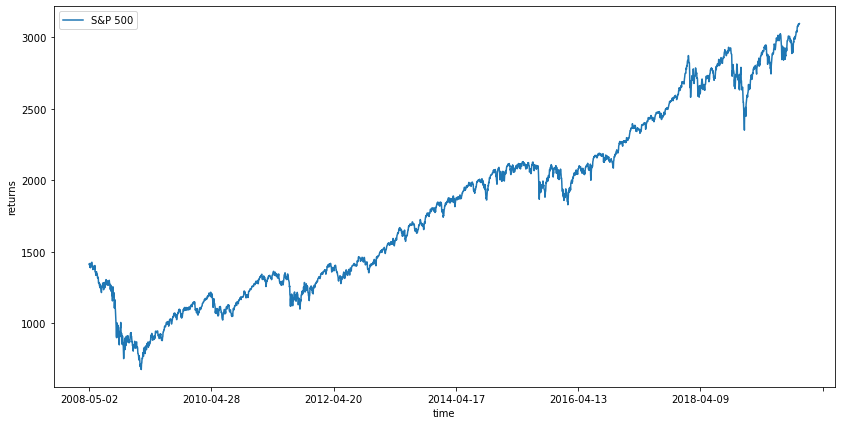

In [4]:
fig, ax = plt.subplots(figsize=(14, 7))
df.plot(y="Close", label='S&P 500', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

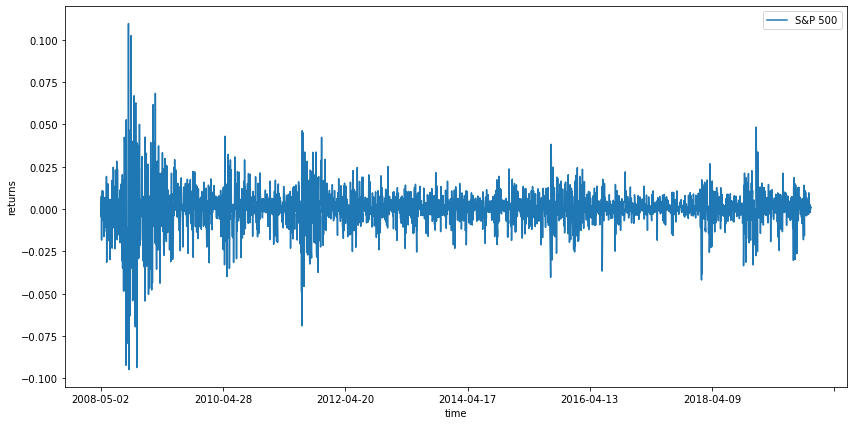

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))
df.plot(y="change", label='S&P 500', ax=ax)
ax.set(xlabel='time', ylabel='returns')
ax.legend();

In [6]:
# r ~ t(nu, lam, mu=0)
# nu ~ Exp(0.1)
# lam = exp(-2*volatility)
# volatility ~ GaussianRandomWalk(sigma=step_size)
# step_size ~ Exp(10)

returns_data = df["change"]

with pm.Model() as model:
    step_size = pm.Exponential('step_size', 10)
    volatility = pm.GaussianRandomWalk('volatility', sigma=step_size, 
                                       shape=len(returns_data))
    nu = pm.Exponential('nu', 0.1)
    returns = pm.StudentT('returns',
                          nu=nu,
                          lam=np.exp(-2*volatility),
                          observed=returns_data)

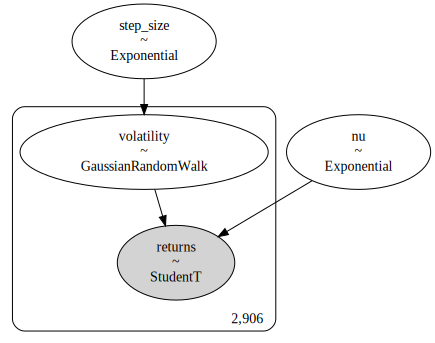

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    inf_data = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, volatility, step_size]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 369 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
inf_data.posterior['volatility'].shape

(2, 2000, 2906)

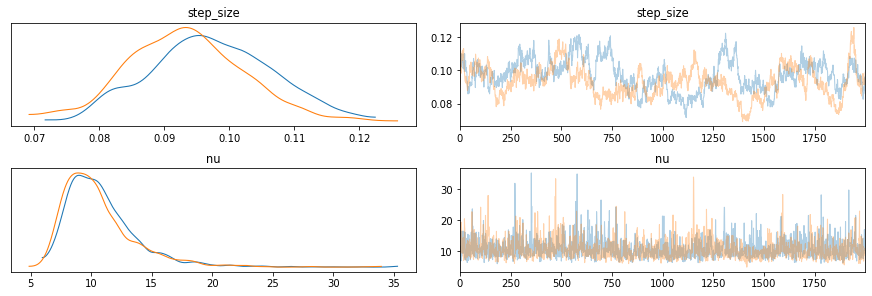

In [10]:
az.plot_trace(inf_data, var_names=['step_size', 'nu'],
             compact=False);

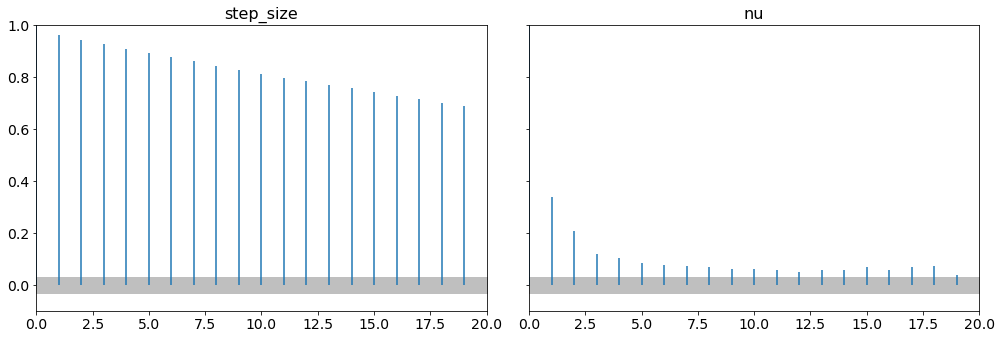

In [11]:
az.plot_autocorr(inf_data, var_names=['step_size', 'nu'], max_lag=20, combined=True)
plt.ylim([-0.1, 1])
plt.show()

In [12]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
volatility[0],-4.804,0.280,-5.329,-4.287,0.004,0.003,4604.0,3250.0,1.00
volatility[1],-4.794,0.265,-5.284,-4.291,0.004,0.003,4565.0,3530.0,1.00
volatility[2],-4.780,0.250,-5.245,-4.315,0.004,0.003,4559.0,3190.0,1.00
volatility[3],-4.764,0.237,-5.201,-4.314,0.003,0.002,4914.0,3243.0,1.00
volatility[4],-4.773,0.233,-5.212,-4.342,0.003,0.002,4856.0,3285.0,1.00
...,...,...,...,...,...,...,...,...,...
volatility[2903],-5.794,0.292,-6.350,-5.251,0.007,0.005,1672.0,3350.0,1.00
volatility[2904],-5.812,0.307,-6.393,-5.226,0.008,0.006,1565.0,2809.0,1.00
volatility[2905],-5.820,0.324,-6.507,-5.267,0.009,0.006,1263.0,2500.0,1.00
step_size,0.095,0.009,0.079,0.114,0.002,0.001,36.0,103.0,1.07


In [13]:
df.index.shape

(2906,)

In [14]:
inf_data.posterior['volatility'].shape

(2, 2000, 2906)

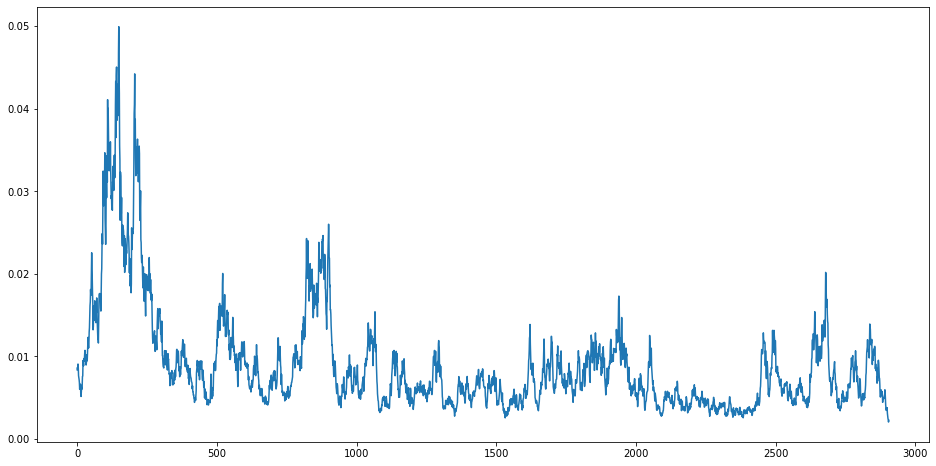

In [15]:
# sample #0 from chain #0 of volatility
plt.figure(figsize=(16, 8))
plt.plot(np.exp(inf_data.posterior['volatility'][0,0,:]));

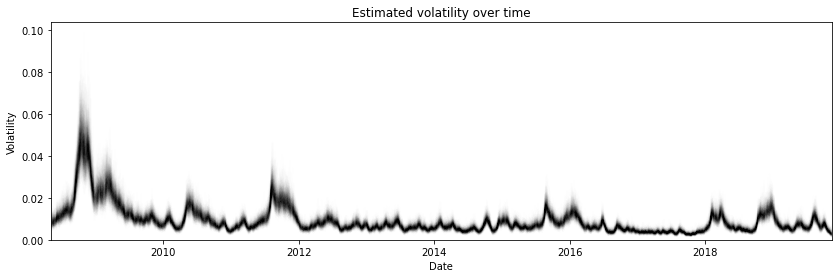

In [16]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(inf_data.posterior['volatility'][0,::5,:]).T  # every fifth from chain0
x_vals = np.vstack([df.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');